# Cost matrix around path intersection

One figure with **two panels**:
- **Left:** **FlexDTW's** cost matrix, zoomed around the intersection (the cost landscape FlexDTW was run on).
- **Right:** **ParFlex's** cost matrix, zoomed around the intersection (the cost landscape ParFlex was run on).

**The two cost matrices need not be the same** (e.g. different features). Each panel shows that algorithm's own cost matrix so you can see why paths diverge: different local costs lead to different path choices. The window is centered at the intersection and sized to show divergences. **Both paths (Flex and ParFlex) are drawn in every panel.** Axes use global (row, col) indices. Uses Levy vs Afanassiev pair by default.

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
# Ensure repo root is on path (run from parflex repo root or from path_divergence_analysis)
repo_root = Path.cwd()
if repo_root.name == "path_divergence_analysis":
    repo_root = repo_root.parent
sys.path.insert(0, str(repo_root))
import import_ipynb
import Parflex
import FlexDTW

In [2]:
# Feature files (Levy vs Afanassiev)
file_1 = "/home/ijain/ttmp/Chopin_Mazurkas_features/matching/Chopin_Op017No4/Chopin_Op017No4_Levy-1951_pid915406-13.npy"
file_2 = "/home/ijain/ttmp/Chopin_Mazurkas_features/matching/Chopin_Op017No4/Chopin_Op017No4_Afanassiev-2001_pid9130-01.npy"

F1 = np.load(file_1, allow_pickle=True)
F2 = np.load(file_2, allow_pickle=True)
L1, L2 = F1.shape[1], F2.shape[1]
print(f"F1: {L1} frames, F2: {L2} frames")

F1: 9379 frames, F2: 17642 frames


In [3]:
# Cost matrix and alignment parameters (match compare_flex_parflex)
steps = np.array([[1, 1], [1, 2], [2, 1]])
weights = np.array([1.25, 3.0, 3.0])
beta = 0.1

C = 1.0 - FlexDTW.L2norm(F1).T @ FlexDTW.L2norm(F2)
buffer_flex = min(L1, L2) * (1 - (1 - beta) * min(L1, L2) / max(L1, L2))

# Global FlexDTW path
best_cost_full, global_flex_path, D, P, B, debug = FlexDTW.flexdtw(
    C, steps=steps, weights=weights, buffer=buffer_flex
)
# ParFlex: Stage 1 + Stage 2
C_check, tiled_result = Parflex.align_system_parflex(F1, F2, steps=steps, weights=weights, beta=beta)
stage2_result = Parflex.parflex_2a(tiled_result, C, beta=beta, show_fig=False, top_k=1)
parflex_wp = stage2_result["stitched_wp"]  # (N, 2) with (row, col)

# Each algorithm can use a different cost matrix (e.g. different features)
C_flex = C                    # cost matrix FlexDTW was run on
C_parflex = C_check           # cost matrix ParFlex was run on (need not equal C_flex)

print(f"Flex path length: {global_flex_path.shape[1]}, ParFlex path length: {len(parflex_wp)}")

Flex path length: 9314, ParFlex path length: 8615


In [4]:
# Normalize to (N, 2) with (row, col) for both paths
def path_to_rows_cols(wp):
    wp = np.asarray(wp)
    if wp.shape[0] == 2:
        return np.column_stack([wp[0], wp[1]])
    return wp[:, :2]

flex_rc = path_to_rows_cols(global_flex_path)
parflex_rc = np.asarray(parflex_wp)[:, :2]
if parflex_rc.shape[1] != 2:
    parflex_rc = parflex_rc.T
print(f"flex_rc shape: {flex_rc.shape}, parflex_rc shape: {parflex_rc.shape}")

flex_rc shape: (9314, 2), parflex_rc shape: (8615, 2)


In [5]:
def find_intersection_regions(flex_rc, parflex_rc, radius=3):
    """Find (flex_index, parflex_index) where paths are within `radius` (L_inf)."""
    parflex_set = set(map(tuple, parflex_rc.astype(int)))
    intersections = []  # (i_flex, j_parflex) where paths are close
    for i, (r, c) in enumerate(flex_rc):
        ri, ci = int(r), int(c)
        for j, (rp, cp) in enumerate(parflex_rc):
            if abs(ri - int(rp)) <= radius and abs(ci - int(cp)) <= radius:
                intersections.append((i, j))
                break
    return intersections

def find_one_intersection_stretch(flex_rc, parflex_rc, radius=2):
    """Return a contiguous stretch of intersection: (i_start, i_end) on flex path."""
    parflex_set = set(tuple(row) for row in parflex_rc.astype(int))
    in_intersection = []
    for i, (r, c) in enumerate(flex_rc):
        ri, ci = int(r), int(c)
        if any(
            abs(ri - rp) <= radius and abs(ci - cp) <= radius
            for (rp, cp) in parflex_set
        ):
            in_intersection.append(i)
    if not in_intersection:
        return None, None
    # One contiguous block in the middle
    i_start = min(in_intersection)
    i_end = max(in_intersection)
    return i_start, i_end

i_start, i_end = find_one_intersection_stretch(flex_rc, parflex_rc, radius=2)
if i_start is not None:
    i_mid = (i_start + i_end) // 2
    print(f"Intersection stretch on flex path: indices {i_start}–{i_end}, center index {i_mid}")
else:
    i_mid = len(flex_rc) // 2
    print(f"No tight intersection found; using path center index {i_mid}")

Intersection stretch on flex path: indices 6321–7029, center index 6675


In [6]:
def extract_window_center(C, flex_rc, parflex_rc, center_row, center_col, half_size=150):
    """Extract a cost-matrix window centered at (center_row, center_col).
    Returns C_patch, flex_global, parflex_global, (r_lo, r_hi, c_lo, c_hi).
    Path segments are in global (row, col) coordinates for correct axes."""
    r0, c0 = center_row, center_col
    r_lo = max(0, r0 - half_size)
    r_hi = min(C.shape[0], r0 + half_size + 1)
    c_lo = max(0, c0 - half_size)
    c_hi = min(C.shape[1], c0 + half_size + 1)
    C_patch = C[r_lo:r_hi, c_lo:c_hi].copy()

    def to_global_in_window(rc, r_lo, r_hi, c_lo, c_hi):
        mask = (rc[:, 0] >= r_lo) & (rc[:, 0] < r_hi) & (rc[:, 1] >= c_lo) & (rc[:, 1] < c_hi)
        return rc[mask].astype(float)

    flex_global = to_global_in_window(flex_rc, r_lo, r_hi, c_lo, c_hi)
    parflex_global = to_global_in_window(parflex_rc, r_lo, r_hi, c_lo, c_hi)
    return C_patch, flex_global, parflex_global, (r_lo, r_hi, c_lo, c_hi)

# Single zoom centered at intersection: 1000 frames before and after the intersection
half = 1000
during_idx = i_mid

# Flex-centered: window centered on Flex path at the intersection
r_flex, c_flex = int(flex_rc[during_idx, 0]), int(flex_rc[during_idx, 1])
C_flex_patch, flex_global_flex, parflex_global_flex, bounds_flex = extract_window_center(
    C_flex, flex_rc, parflex_rc, r_flex, c_flex, half_size=half
)

# ParFlex-centered: window centered on ParFlex path at the intersection
pf_during_idx = int(np.argmin(np.abs(parflex_rc[:, 0] - flex_rc[during_idx, 0]) + np.abs(parflex_rc[:, 1] - flex_rc[during_idx, 1])))
r_pf, c_pf = int(parflex_rc[pf_during_idx, 0]), int(parflex_rc[pf_during_idx, 1])
C_pf, flex_global_pf, parflex_global_pf, bounds_pf = extract_window_center(
    C_parflex, flex_rc, parflex_rc, r_pf, c_pf, half_size=half
)

Saved: /home/ijain/parflex/path_divergence_analysis/cost_intersection_flex_and_parflex.png


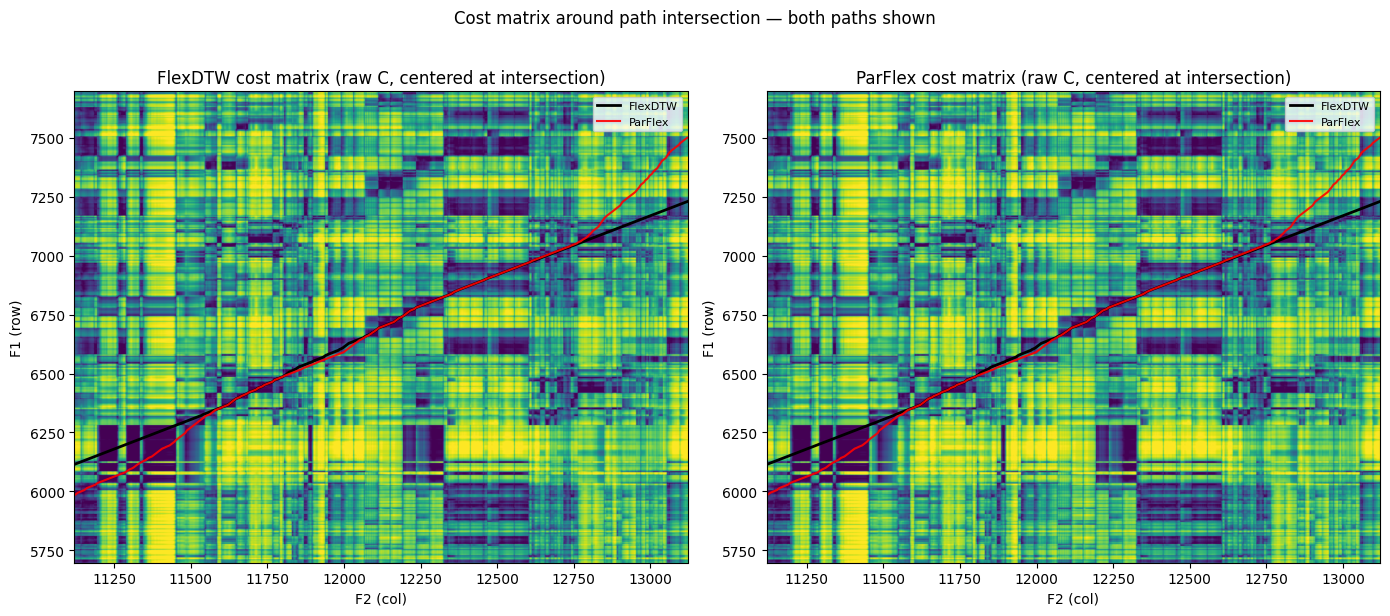

In [7]:
def plot_cost_window_global(ax, C_patch, flex_global, parflex_global, bounds, title, vmin=None, vmax=None):
    """Draw cost matrix patch (raw) and both paths in global (row, col) coordinates; axes show actual indices."""
    r_lo, r_hi, c_lo, c_hi = bounds
    if vmin is None:
        vmin = np.nanpercentile(C_patch, 2)
    if vmax is None:
        vmax = np.nanpercentile(C_patch, 98)
    # extent: (left, right, bottom, top) = (c_lo, c_hi, r_lo, r_hi) so x=col, y=row with correct values
    ax.imshow(
        C_patch,
        aspect="auto",
        origin="lower",
        cmap="viridis",
        vmin=vmin,
        vmax=vmax,
        extent=[c_lo, c_hi, r_lo, r_hi],
    )
    if len(flex_global) > 1:
        ax.plot(flex_global[:, 1], flex_global[:, 0], '-', color='black', linewidth=2, label='FlexDTW')
    if len(parflex_global) > 1:
        ax.plot(parflex_global[:, 1], parflex_global[:, 0], '-', color='red', linewidth=1.5, alpha=0.9, label='ParFlex')
    ax.set_title(title)
    ax.set_xlabel("F2 (col)")
    ax.set_ylabel("F1 (row)")
    ax.legend(loc="upper right", fontsize=8)

# Shared color scale from both raw cost patches
vmin_global = min(np.nanpercentile(C_flex_patch, 2), np.nanpercentile(C_pf, 2))
vmax_global = max(np.nanpercentile(C_flex_patch, 98), np.nanpercentile(C_pf, 98))

# Two panels: Flex-centered raw cost matrix (left), ParFlex-centered raw cost matrix (right)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_cost_window_global(
    axes[0],
    C_flex_patch,
    flex_global_flex,
    parflex_global_flex,
    bounds_flex,
    "FlexDTW cost matrix (raw C, centered at intersection)",
    vmin=vmin_global,
    vmax=vmax_global,
)
plot_cost_window_global(
    axes[1],
    C_pf,
    flex_global_pf,
    parflex_global_pf,
    bounds_pf,
    "ParFlex cost matrix (raw C, centered at intersection)",
    vmin=vmin_global,
    vmax=vmax_global,
)
fig.suptitle("Cost matrix around path intersection — both paths shown", fontsize=12, y=1.02)
plt.tight_layout()
if Path.cwd().name == 'path_divergence_analysis':
    out_dir = Path.cwd()
else:
    out_dir = Path.cwd() / 'path_divergence_analysis'
    out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / 'cost_intersection_flex_and_parflex.png'
plt.savefig(out_path, dpi=150, bbox_inches='tight')
print(f"Saved: {out_path}")
plt.show()

## Check cost values at specific indices in parflex and flex

In [8]:
def find_chunk_containing(chunks_dict, r, c):
    """Return (chunk_i, chunk_j, local_r, local_c) for the chunk that contains global (r, c), or None."""
    r, c = int(r), int(c)
    for (i, j), data in chunks_dict.items():
        start_1, end_1, start_2, end_2 = data['bounds']
        if start_1 <= r < end_1 and start_2 <= c < end_2:
            return (i, j, r - start_1, c - start_2)
    return None

def cost_at_coordinate(C_flex, C_parflex, tiled_result, flex_rc, parflex_rc, r, c, tol=0):
    """Report raw cost at (r, c) from FlexDTW and from ParFlex (in the specific chunk).
    Also reports whether Flex / ParFlex paths pass through this coordinate.
    tol: max L_inf distance to consider 'on path' (0 = exact integer match only)."""
    r, c = int(r), int(c)
    chunks_dict = tiled_result.get('chunks_dict', {})

    # FlexDTW raw cost (global matrix)
    cost_flex = float(C_flex[r, c])

    # ParFlex raw cost: look up in the chunk that contains (r, c)
    chunk_info = find_chunk_containing(chunks_dict, r, c)
    if chunk_info is not None:
        chunk_i, chunk_j, local_r, local_c = chunk_info
        C_chunk = chunks_dict[(chunk_i, chunk_j)]['C']
        cost_parflex = float(C_chunk[local_r, local_c])
    else:
        cost_parflex = None
        chunk_i = chunk_j = local_r = local_c = None

    def on_path(rc, r, c, tol):
        if tol == 0:
            hit = np.where((rc[:, 0].astype(int) == r) & (rc[:, 1].astype(int) == c))[0]
        else:
            hit = np.where((np.abs(rc[:, 0] - r) <= tol) & (np.abs(rc[:, 1] - c) <= tol))[0]
        return hit

    flex_hit = on_path(flex_rc, r, c, tol)
    parflex_hit = on_path(parflex_rc, r, c, tol)

    print(f"Coordinate (row, col) = ({r}, {c})")
    print(f"  FlexDTW cost matrix C_flex[{r},{c}] = {cost_flex:.6f}")
    if chunk_info is not None:
        print(
            f"  ParFlex cost (chunk ({chunk_i},{chunk_j}) local ({local_r},{local_c})) = {cost_parflex:.6f}"
        )
    else:
        print("  ParFlex: (r,c) not inside any chunk bounds")
    print()

    if len(flex_hit) > 0:
        print(f"Flex path passes through (r,c): path index(es) {flex_hit}")
    else:
        dr = np.abs(flex_rc[:, 0] - r)
        dc = np.abs(flex_rc[:, 1] - c)
        i_flex = np.argmin(dr + dc)
        dist = max(dr[i_flex], dc[i_flex])
        print(f"Flex path does not pass through (r,c). Closest: path index {i_flex}, L_inf distance = {dist:.2f}")
    print()

    if len(parflex_hit) > 0:
        print(f"ParFlex path passes through (r,c): path index(es) {parflex_hit}")
    else:
        dr = np.abs(parflex_rc[:, 0] - r)
        dc = np.abs(parflex_rc[:, 1] - c)
        i_pf = np.argmin(dr + dc)
        dist = max(dr[i_pf], dc[i_pf])
        print(f"ParFlex path does not pass through (r,c). Closest: path index {i_pf}, L_inf distance = {dist:.2f}")

    return cost_flex, cost_parflex, flex_hit, parflex_hit


# Set (row, col) to inspect (e.g. from the plot; row = F1 index, col = F2 index)
check_r, check_c = 9378, 12250  # edit to check another coordinate
cost_at_coordinate(C_flex, C_parflex, tiled_result, flex_rc, parflex_rc, check_r, check_c, tol=1)


Coordinate (row, col) = (9378, 12250)
  FlexDTW cost matrix C_flex[9378,12250] = 0.308072
  ParFlex cost (chunk (2,3) local (1380,253)) = 0.308072

Flex path does not pass through (r,c). Closest: path index 6766, L_inf distance = 2590.00

ParFlex path does not pass through (r,c). Closest: path index 6195, L_inf distance = 2590.00


(0.30807191133499146,
 0.30807191133499146,
 array([], dtype=int64),
 array([], dtype=int64))

In [9]:
# (Figure already saved in previous cell. Run from repo root to save in path_divergence_analysis/.)